In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split 

train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

train_data["SalePrice"].describe()

X = train_data.drop('SalePrice', axis=1)
y = train_data['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [60]:
cols_with_missing = [col for col in train_data.columns if train_data[col].isnull().any()]
print(len(cols_with_missing), "columns have missing values.")
print("Columns with missing values in Train Data:", cols_with_missing)

# Try dropping cols with missing values 
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_test = X_test.drop(cols_with_missing, axis=1)


19 columns have missing values.
Columns with missing values in Train Data: ['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


In [61]:
# Check for categorical and numeric columns
categorical_cols = [col for col in reduced_X_train.columns if X_train[col].dtype == "object"]
numeric_cols = [col for col in reduced_X_train.columns if X_train[col].dtype in ['int64', 'float64']]

print(f"Categorical columns: {len(categorical_cols)}")
print(f"Numeric columns: {len(numeric_cols)}")

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Encode categorical variables
preprocessor_missing_columns = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)


Categorical columns: 27
Numeric columns: 34


In [62]:
# Imputing the missing values using SimpleImputer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# Numeric and categorical columns
numeric_columns = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]
categorical_columns = [col for col in X_train.columns if X_train[col].dtype == "object"]

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median', add_indicator=True))  # median + indicator
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_impute = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_columns),
        ("cat", categorical_transformer, categorical_columns)
    ]
)

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline

linear_regressor = Pipeline(steps=[("preprocessor", preprocessor_missing_columns),
                                  ("regressor", LinearRegression())])

linear_regressor.fit(reduced_X_train, y_train)
linear_predictions = linear_regressor.predict(reduced_X_test)
mean_absolute_error_linear = mean_absolute_error(y_test, linear_predictions)
print("Mean Absolute Error (Linear Regression):", mean_absolute_error_linear)


Mean Absolute Error (Linear Regression): 20131.164325728143


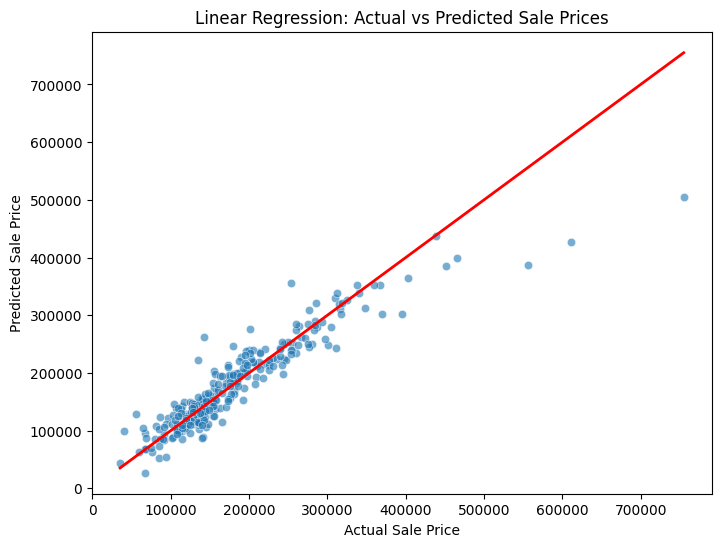

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=linear_predictions, alpha=0.6)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Linear Regression: Actual vs Predicted Sale Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # perfect line
plt.show()


Mean Absolute Error (Linear Regression with Imputation): 20594.868226824587


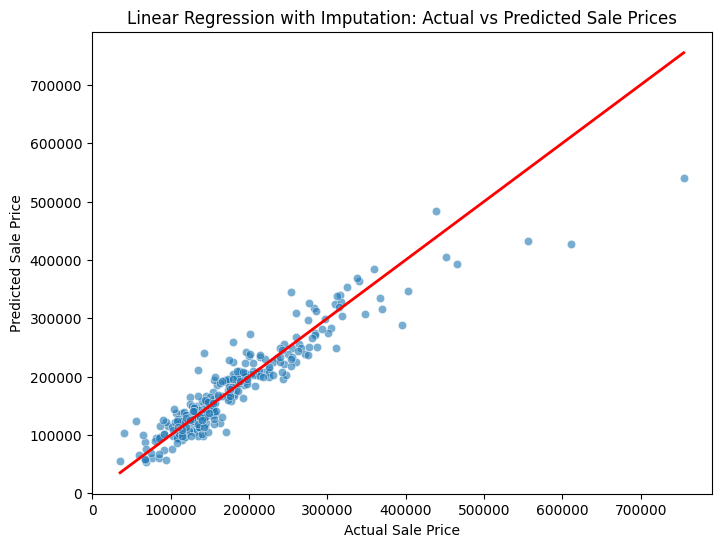

In [65]:
# Now We'll try imputing missing values instead of dropping columns
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

numeric_columns = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]
categorical_columns = [col for col in X_train.columns if X_train[col].dtype == "object"]

numeric_transformer = Pipeline(steps=[
    ('imputer', imputer),
    ("add_indication", SimpleImputer(strategy='median', fill_value=-1))
])  
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_impute = ColumnTransformer(
    transformers=[ ("num", numeric_transformer, numeric_columns), ("cat", categorical_transformer, categorical_columns)]
)

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
linear_regressor_impute = Pipeline(steps=[("preprocessor", preprocessor_impute),
                                  ("regressor", LinearRegression())])
linear_regressor_impute.fit(X_train, y_train)
imputed_linear_predictions = linear_regressor_impute.predict(X_test)
mean_absolute_error_imputed_linear = mean_absolute_error(y_test, imputed_linear_predictions)
print("Mean Absolute Error (Linear Regression with Imputation):", mean_absolute_error_imputed_linear)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=imputed_linear_predictions, alpha=0.6
)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Linear Regression with Imputation: Actual vs Predicted Sale Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # perfect line
plt.show()

The MAE increased with imputation as opposed to simply dropping the missing columns. However, using LinearRegression, this is expected. Hence we move forward to using a different Regressor.


Random Forest MAE (with imputation): 17558.775335366645


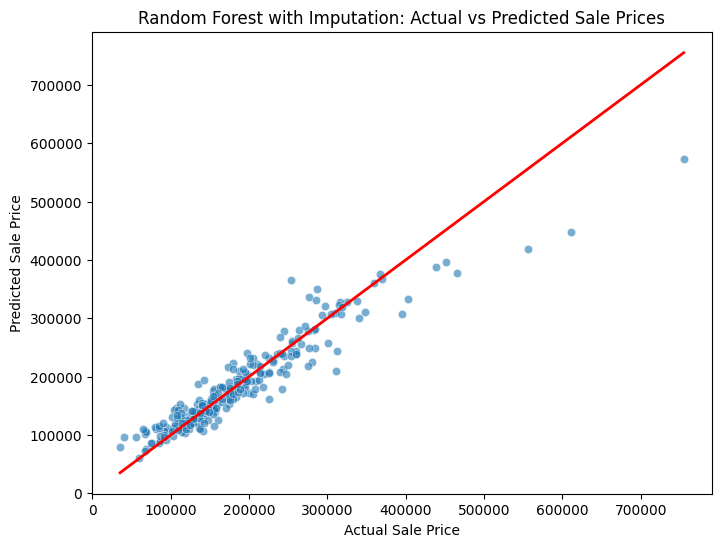

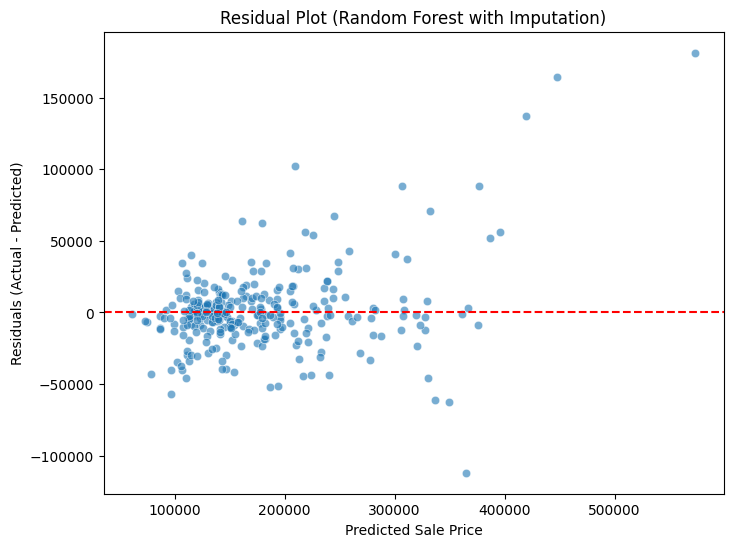

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error



# Random Forest pipeline
rf_regressor_impute = Pipeline(steps=[
    ("preprocessor", preprocessor_impute),
    ("regressor", RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1))
])

# Fit model
rf_regressor_impute.fit(X_train, y_train)

# Predict
imputed_rf_predictions = rf_regressor_impute.predict(X_test)

# MAE
mae = mean_absolute_error(y_test, imputed_rf_predictions)
print("Random Forest MAE (with imputation):", mae)

# Visualization: Predicted vs Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=imputed_rf_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # perfect line
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Random Forest with Imputation: Actual vs Predicted Sale Prices")
plt.show()

# Optional: Residual plot
residuals = y_test - imputed_rf_predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=imputed_rf_predictions, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sale Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot (Random Forest with Imputation)")
plt.show()


Random Forest MAE (ignoring missing columns): 17558.775335366645


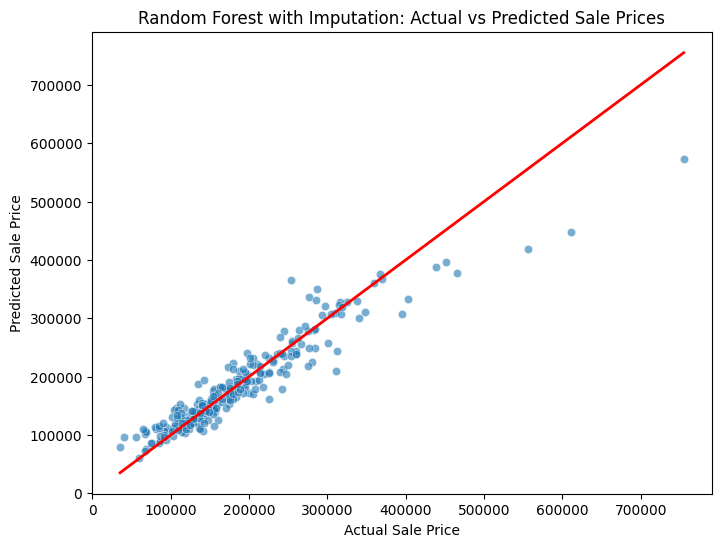

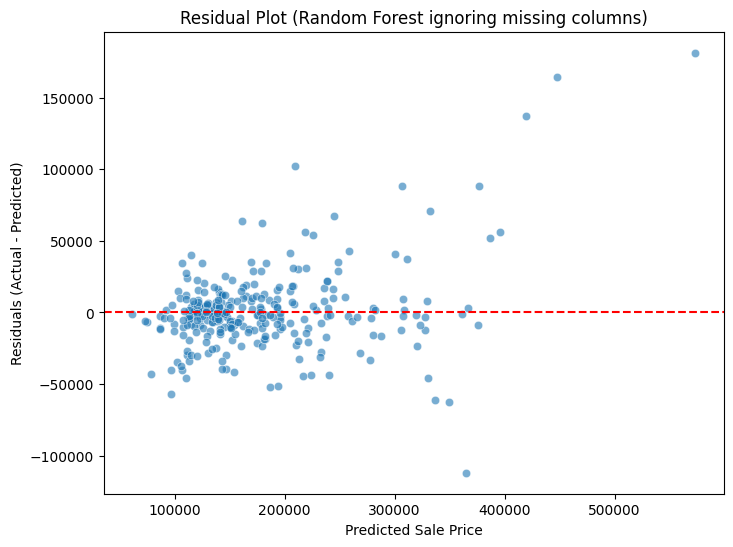

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Numeric and categorical columns
numeric_columns = [col for col in reduced_X_train.columns if X_train[col].dtype in ['int64', 'float64']]
categorical_columns = [col for col in reduced_X_train.columns if X_train[col].dtype == "object"]

preprocessor_missing_columns = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_columns),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_columns),
    ]
)


# Random Forest pipeline
rf_regressor_impute = Pipeline(steps=[
    ("preprocessor", preprocessor_impute),
    ("regressor", RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1))
])

# Fit model
rf_regressor_impute.fit(X_train, y_train)

# Predict
imputed_rf_predictions = rf_regressor_impute.predict(X_test)

# MAE
mae = mean_absolute_error(y_test, imputed_rf_predictions)
print("Random Forest MAE (ignoring missing columns):", mae)

# Visualization: Predicted vs Actual
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=imputed_rf_predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=2)  # perfect line
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Random Forest with Imputation: Actual vs Predicted Sale Prices")
plt.show()

# Optional: Residual plot
residuals = y_test - imputed_rf_predictions
plt.figure(figsize=(8, 6))
sns.scatterplot(x=imputed_rf_predictions, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Sale Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot (Random Forest ignoring missing columns)")
plt.show()


The missing columns seem to be unimportant, hence dropping them is the way to continue improving the MAE.

In [74]:
from xgboost import XGBRegressor
preprocessor_type = "missing"  

if preprocessor_type == "impute":
    preprocessor = preprocessor_impute
else:
    preprocessor = preprocessor_missing_columns

xgb_regressor = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(n_estimators=200, max_depth=15, learning_rate=0.1, random_state=42, n_jobs=-1))
])

if (preprocessor_type =="impute"):
    xgb_regressor.fit(X_train, y_train)
    xgb_predictions = xgb_regressor.predict(X_test)
    xgb_mae = mean_absolute_error(y_test, xgb_predictions)
    print("XGBoost MAE (ignoring with imputation):", xgb_mae)
else:
    xgb_regressor.fit(reduced_X_train, y_train)
    xgb_predictions = xgb_regressor.predict(reduced_X_test)
    xgb_mae = mean_absolute_error(y_test, xgb_predictions)
    print("XGBoost MAE (ignoring missing columns):", xgb_mae)

XGBoost MAE (ignoring missing columns): 18694.984375
